In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  shuffle=True,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


2025-05-11 21:41:54.037264: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-11 21:41:54.037421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-11 21:41:54.037431: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-11 21:41:54.037668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-11 21:41:54.037687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

2025-05-11 21:41:56.908328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


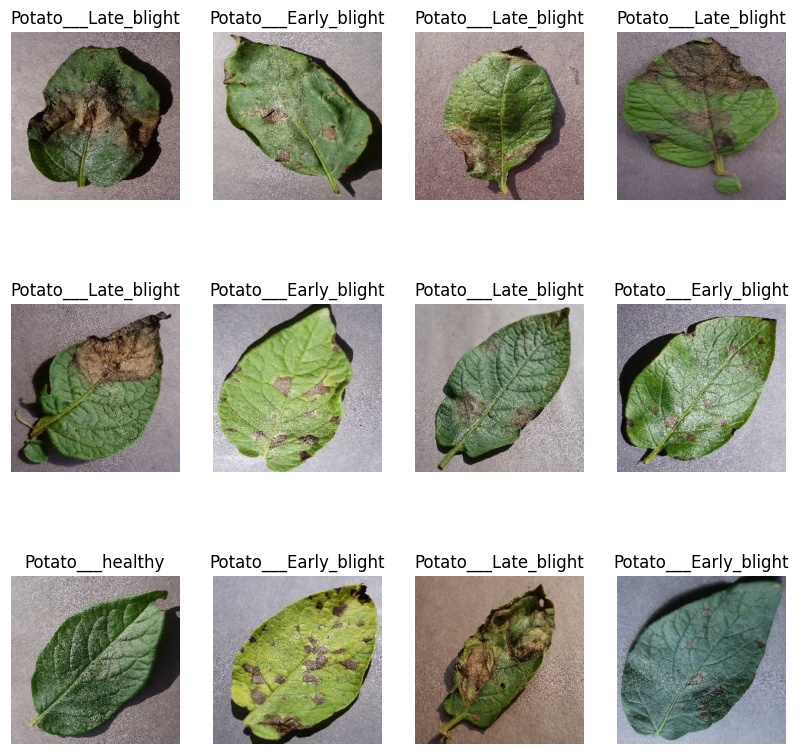

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3, 4, i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[labels_batch[i]])
      plt.axis("off")


In [11]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffed=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffed:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [21]:
# caching & prefetching
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
# Scaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255)
])

In [23]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

## Build a CNN model

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(n_classes, activation='softmax')
  ])

model.build(input_shape=input_shape)

/Users/zhouqianqian/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  verbose=1,
  validation_data=val_ds,
)

Epoch 1/50


2025-05-11 21:42:19.941790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4726 - loss: 0.9360 - val_accuracy: 0.5833 - val_loss: 0.8097
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.6352 - loss: 0.7432 - val_accuracy: 0.7202 - val_loss: 0.6200
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7835 - loss: 0.4838 - val_accuracy: 0.8698 - val_loss: 0.3449
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8585 - loss: 0.3440 - val_accuracy: 0.9167 - val_loss: 0.2829
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9098 - loss: 0.2323 - val_accuracy: 0.8750 - val_loss: 0.4033
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8823 - loss: 0.2888 - val_accuracy: 0.9115 - val_loss: 0.2296
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9291 - loss: 0.2037 - val_accuracy: 0.9062 - val_loss: 0.3051
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9201 - loss: 0.2025 - val_accuracy: 0.9010 - val

In [28]:
socres = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0080


In [29]:
socres

[0.009112006053328514, 1.0]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

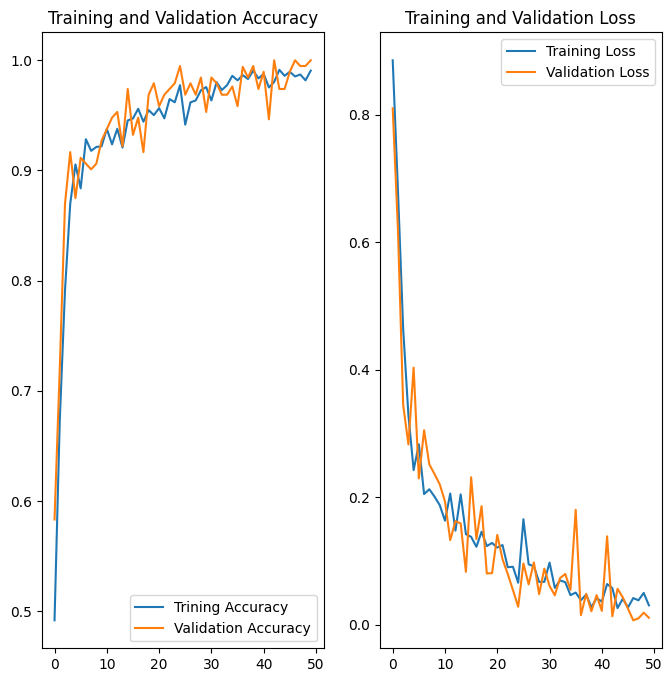

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Trining Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
First image's actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
predicted label: Potato___Late_blight


2025-05-11 21:49:46.064040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


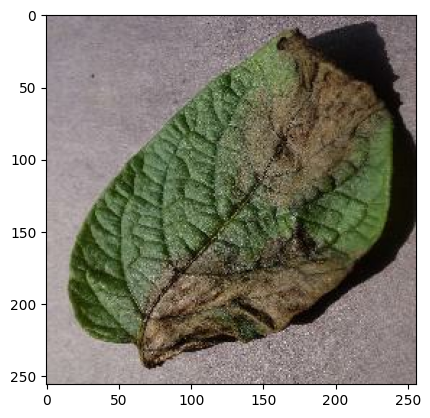

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    bacth_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(bacth_prediction[0])]) # the highest probability and find the class name

In [36]:
def predict(model, img):
  img_arry = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_arry = tf.expand_dims(img_arry, axis=0) # create a batch

  predictions = model.predict(img_arry)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = tf.nn.softmax(predictions[0])
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2025-05-11 21:49:52.208758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


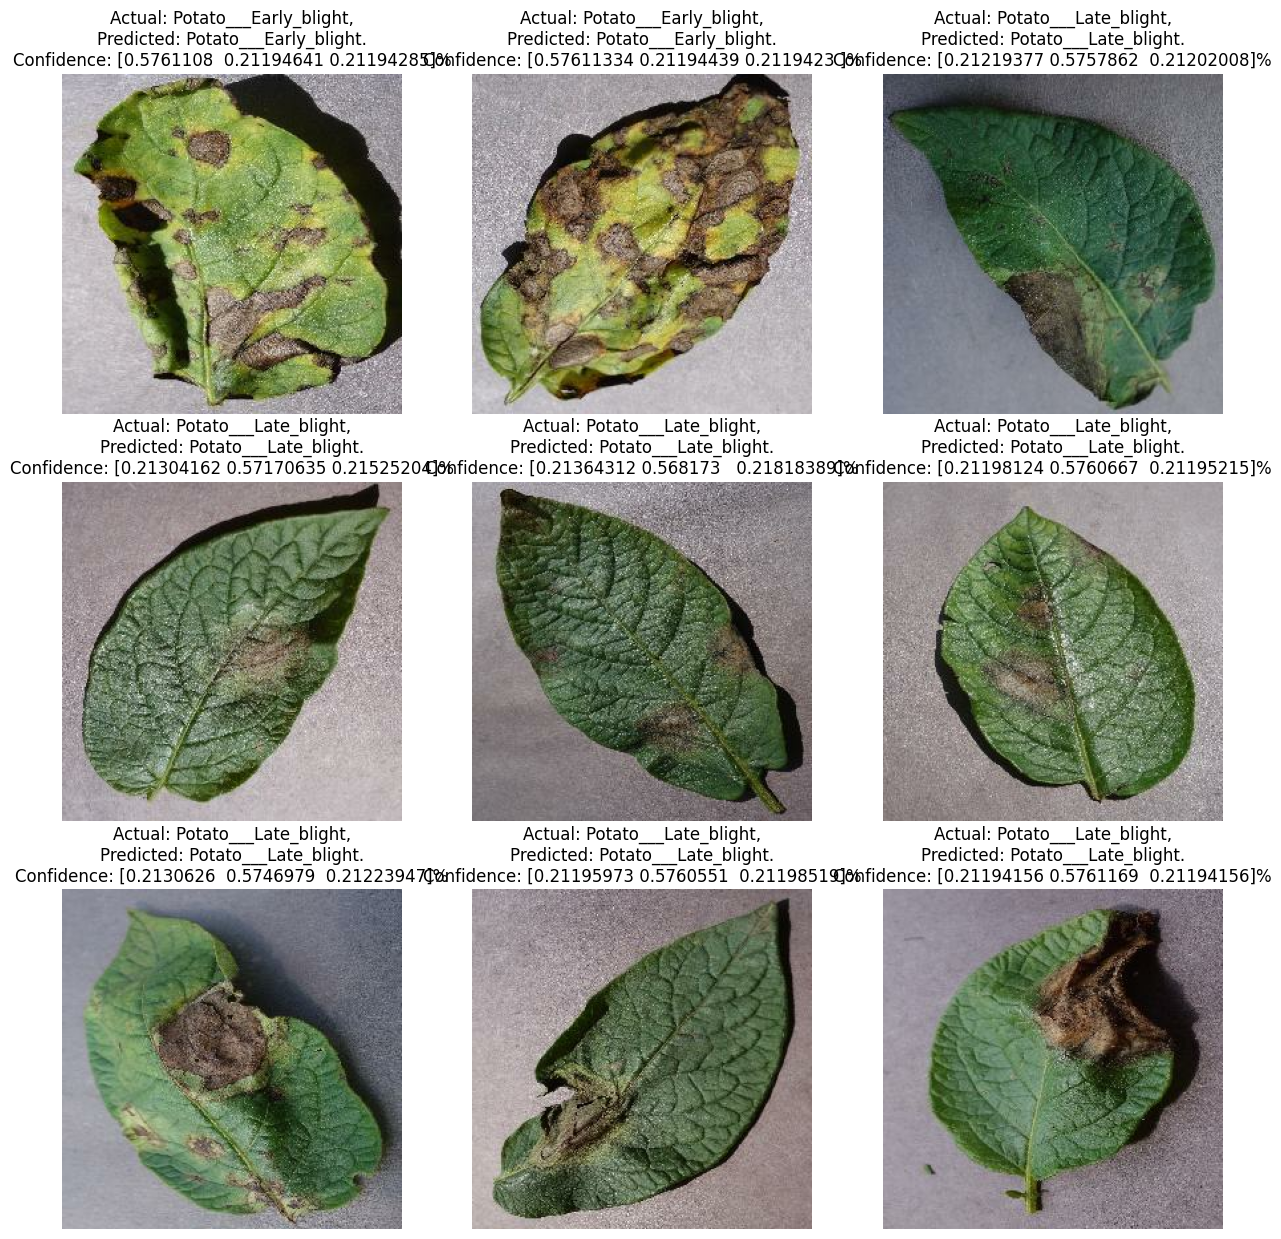

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")

        plt.axis("off")

In [38]:
model.save("plant_disease_model.h5")
